In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
%matplotlib inline

import time
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import math

from gym.envs.toy_text.frozen_lake import LEFT, RIGHT, DOWN, UP
from gym.envs.toy_text import frozen_lake, discrete

import gym
from gym.envs.registration import register

register(
    id='D4x4-FrozenLake-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False})


""" 
    env: gym.core.Environment
    Environment to play on.

    env.P: dictionary
    It is from gym.core.Environment
    P[state][action] is tuples with (probability, nextstate, reward, terminal)
    
    env.nS: int
    count of states 
    
    env.nA: int
    count of actions available
    
    action_space: discrete
                LEFT = 0
                DOWN = 1
                RIGHT = 2
                UP = 3
    ENVIRONMENT: 
                "SFFF",
                "FHFH",
                "FFFH",
                "HFFG"
"""

def print_policy(policy, action_names):
    """ 
    Print the policy in human-readable format.
    """
    str_policy = policy.astype('str')
    for action_num, action_name in action_names.items():
        np.place(str_policy, policy == action_num, action_name)

    print(str_policy[0:4])
    print(str_policy[4:8])
    print(str_policy[8:12])
    print(str_policy[12:16])
    
    return str_policy

action_names = {LEFT: 'LEFT', RIGHT: 'RIGHT', DOWN: 'DOWN', UP: 'UP'}

In [2]:
env = gym.make('D4x4-FrozenLake-v0')
grid = 4
gamma = 0.9 # Change this to play with it


Doing Value Iteration
Total time taken: 0.0497620105743
Total Value Iteration Steps: 43
Policy:
['RIGHT' 'RIGHT' 'DOWN' 'LEFT']
['DOWN' 'UP' 'DOWN' 'UP']
['RIGHT' 'RIGHT' 'DOWN' 'UP']
['UP' 'RIGHT' 'RIGHT' 'UP']


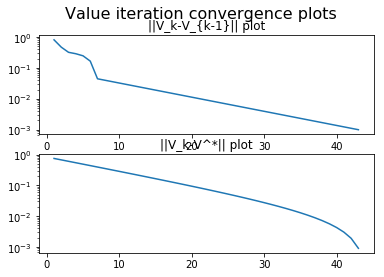

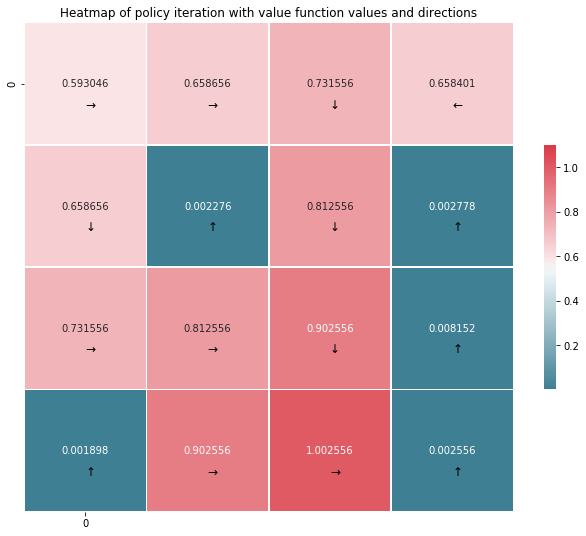

In [3]:
########################################################################
######################### Value iteration ##############################
########################################################################


def value_iteration(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """
    Runs value iteration for a given gamma and environment. Return 
    the value function and the number of iterations it took to converge.
        See section 4.4 of Reinforcement Learning: An Introduction (Adaptive Computation 
        and Machine Learning) by Sutton and Barto
    """
    value_func_old = np.random.rand(env.nS)
    value_func_new = np.zeros(env.nS)
    value_func_collect = np.zeros((env.nS,max_iterations))
    delta_collect = np.zeros(max_iterations)

    for iteration in range(max_iterations):
        delta=0
        for s in range(env.nS):
            max_value_func = -1
            
            # Refer Figure 4.5 for the algorithm
            # Parse through env.nA for finding the maximum
            # Using env.P[s][a] implement the V(s) updation
                                
            # Enter your code here
            
            ## Hint: Start with using for loops accessing 
            ## the actions and next states 
            ## via env.nA and env.P[s][a] respectively
            
            for a in range(env.nA): 
                
                value_func_temp = 0

                for p, next_s, reward, _ in env.P[s][a]:
                    value_func_temp += p*(reward + gamma* value_func_old[next_s])

                max_value_func = max(max_value_func,value_func_temp)
                
            # Few code compatibility instructions:
            ### Updated V(s) must be in variable "max_value_func"
            ### The older Value function V(s) is accessed by the variable "value_func_old"
                    
            diff=abs(value_func_old[s]-max_value_func)
            delta=max(delta,diff)
            value_func_new[s]=max_value_func

        delta_collect[iteration] = delta
        value_func_old = value_func_new
        value_func_collect[:,iteration] = value_func_old
        # Stopping criteria: STOP when the sup norm of (V_k-V_{k-1}) is less than some tolerance level(it's 1e-3 here).
        if delta<=tol: break

    temp=np.repeat(value_func_collect[:,iteration], iteration, axis=0)
    temp=temp.reshape(16,iteration)
    temp1 = abs(value_func_collect[:,0:iteration]-temp);
    distance_from_converged_value_func = temp1.max(axis=0)

    fig = plt.figure()
    fig.suptitle("Value iteration convergence plots", fontsize=16)
    ax = plt.subplot(2,1,1)
    ax.plot(range(1,iteration+1),delta_collect[0:iteration])
    ax.set_title('||V_k-V_{k-1}|| plot')
    ax.set_yscale('log')


    ax = plt.subplot(2,1,2)
    ax.plot(range(1,iteration+1),distance_from_converged_value_func)
    ax.set_title('||V_k-V^*|| plot')
    ax.set_yscale('log')

    return value_func_new, iteration


def value_function_to_policy(env, gamma, value_function):
    """
    Mapping actions for each state using the value_function to get a policy
        See section 4.4 of Reinforcement Learning: An Introduction (Adaptive Computation and Machine Learning) by Sutton and Barto
    """
    policy=np.zeros(env.nS,dtype='int')
    for s in range(env.nS):
        max_value_func=-1
        max_action=-1
        
        # Copy and paste the V(s) updation which you've implemented in the 
        # value_iteration function here. Required changes explained further:
        
        for a in range(env.nA): 
                
            value_func_temp = 0

            for p, next_s, reward, _ in env.P[s][a]:
                value_func_temp += p*(reward + gamma* value_function[next_s])

            max_value_func = max(max_value_func,value_func_temp)
            
            if value_func_temp == max_value_func :
                max_action = a
                
        # In addition to what you did before, 
        # return action which is the best (according to maximum V(s))
        # assign that action to the variable "max_action"
        
        policy[s]=max_action

    return policy


print("\nDoing Value Iteration")
start_time=time.time()
value_function,value_iters=value_iteration(env,gamma)
print("Total time taken: "+str((time.time()-start_time)))
print("Total Value Iteration Steps: "+str(value_iters))
print("Policy:")
policy=value_function_to_policy(env,gamma,value_function)
policy_str=print_policy(policy,action_names)

f, ax = plt.subplots(figsize=(11, 9))
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
reshaped=np.reshape(value_function,(grid,grid))
seaborn.heatmap(reshaped, cmap=cmap, vmax=1.1,
            square=True, xticklabels=grid+1, yticklabels=grid+1,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True, fmt="f")
counter=0
for j in range(0, 4):
    for i in range(0, 4):
        if policy_str[counter]=="DOWN":
            plt.text(i+0.5, j+0.7, u'\u2193', fontsize=12)
        elif policy_str[counter]=="UP":
            plt.text(i+0.5, j+0.7, u'\u2191', fontsize=12)
        elif policy_str[counter]=="LEFT":
            plt.text(i+0.5, j+0.7, u'\u2190', fontsize=12)
        else:
            plt.text(i+0.5, j+0.7, u'\u2192', fontsize=12)
        counter=counter+1

plt.title('Heatmap of policy iteration with value function values and directions')
plt.show()


In [4]:
########################################################################
#################### Final policy animation ############################
########################################################################
print("Final Policy Animation")

def run_policy(env,gamma,policy):
    initial_state = env.reset()
    env.render()
    current_state = initial_state
    while True:
        nextstate, reward, done, debug_info = env.step(policy[current_state])
        env.render()

        if done:
            break

        current_state=nextstate
        time.sleep(1)


Final Policy Animation


In [5]:
run_policy(env,gamma,policy)


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
